In [33]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from math import * 

print("The current directory is: ")
print(os.getcwd())
if not os.getcwd().endswith("Abaqus-Hardening-Seq-2-Seq-Project"):
    # Move up two directories
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
print("The current directory is: ")
print(os.getcwd())


The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project
The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project


In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from configs.chosen_project import *
from src.stage1_global_configs import *

chosen_project_path = "configs/global_config_CP1000_RD_20C.json"

global_configs = main_global_configs(chosen_project_path)

all_paths = global_configs['all_paths']
objectives = global_configs['objectives']


START RUNNING FROM *** 2024-09-20 19:53:20 ***

= Stage 1: Loading configs and all paths =

Welcome to Abaqus Seq2Seq flow curve calibration project

The configurations you have chosen: 

+--------------------------+------------------------------------------------------------------+
|      Global Configs      |                           User choice                            |
+--------------------------+------------------------------------------------------------------+
|         PROJECT          |                          CP1000_RD_20C                           |
|        OBJECTIVES        |        CHD2, CHD4, NDBR2p5, NDBR6, NDBR15, NDBR40, SH115         |
|       PROJECT_PATH       | c:\Users\springnuance\Desktop\Abaqus-Hardening-Seq-2-Seq-Project |
|    TRAINING_DATA_PATH    |                   training_data/CP1000_RD_20C                    |
|         LOG_PATH         |                        log/CP1000_RD_20C                         |
|       MODELS_PATH        |               

In [36]:
def generate_mean_FD_curve(displacement_list, force_list):
    min_disp_list = []
    max_disp_list = []
    num_points_list = []
    for i in range(len(displacement_list)):
        min_disp_list.append(np.min(displacement_list[i]))
        max_disp_list.append(np.max(displacement_list[i]))
        num_points_list.append(len(displacement_list[i]))
    mean_min_disp = np.mean(min_disp_list)
    mean_max_disp = np.mean(max_disp_list)
    mean_num_points = int((np.mean(num_points_list)))
    
    # import interp1d
    from scipy.interpolate import interp1d
    
    mean_force_array = []
    mean_disp = np.linspace(mean_min_disp, mean_max_disp, mean_num_points)
    for i in range(len(displacement_list)):
        f = interp1d(displacement_list[i], force_list[i], kind='linear', fill_value='extrapolate')
        mean_force_array.append(f(np.linspace(mean_min_disp, mean_max_disp, mean_num_points)))
    mean_force_array = np.array(mean_force_array)
    mean_force = np.mean(mean_force_array, axis=0)

    return mean_disp, mean_force



(0.0, 1.0, 0.0, 1.0)

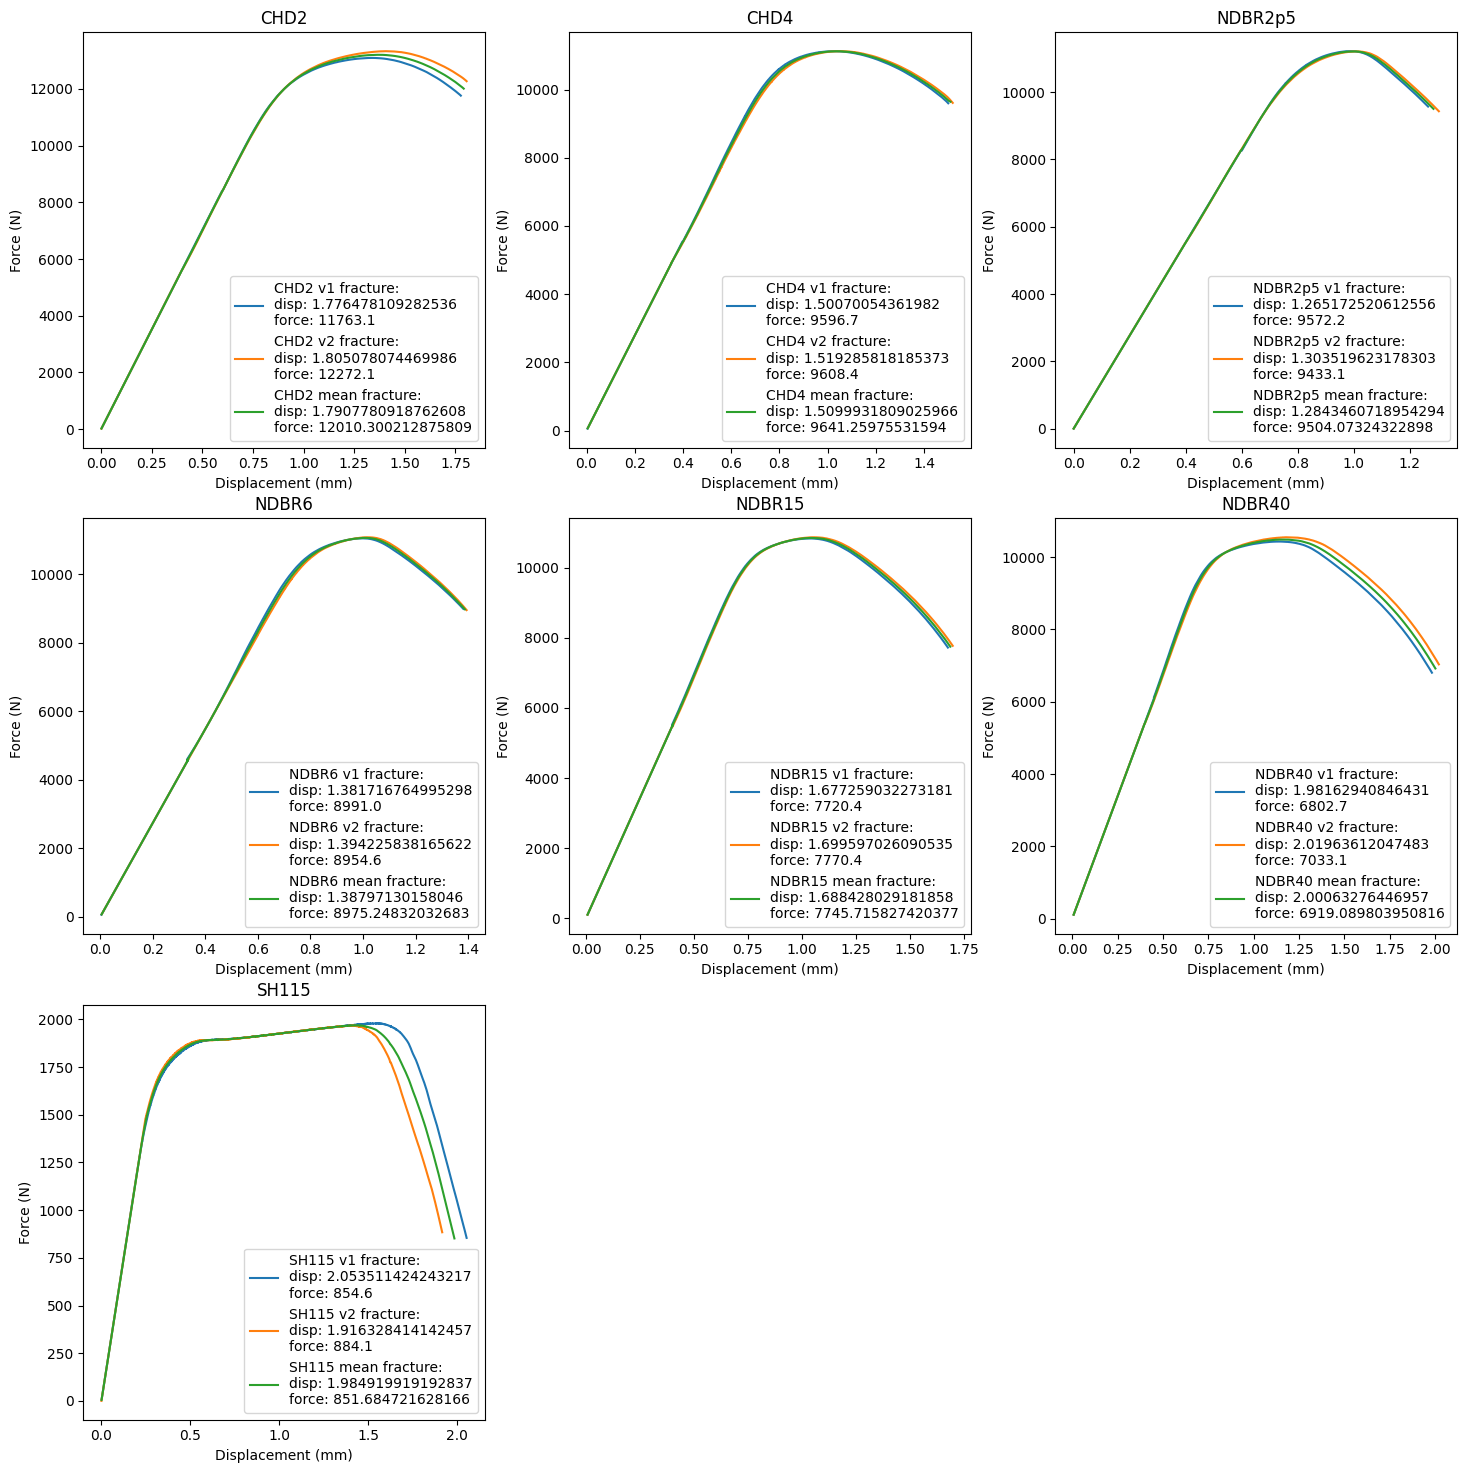

In [37]:
targets_path = all_paths['targets_path']

mean_disp_dict = {}
mean_force_dict = {}

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.tight_layout(pad=3.0)

# We collapse the index of ax to 1D
ax = ax.ravel()

for i, objective in enumerate(objectives):
    FD_curve_v1 = pd.read_excel(f"{targets_path}/{objective}/FD_curve_measurement_v1.xlsx", engine='openpyxl')
    FD_curve_v2 = pd.read_excel(f"{targets_path}/{objective}/FD_curve_measurement_v2.xlsx", engine='openpyxl')
    
    # # We add the column  displacement/m to both df as the first column and save them back
    # FD_curve_v1["displacement/m"] = FD_curve_v1["displacement/mm"]/1000
    # FD_curve_v2["displacement/m"] = FD_curve_v2["displacement/mm"]/1000

    # FD_curve_v1.to_excel(f"{targets_path}/{objective}/FD_curve_measurement_v1.xlsx", index=False)
    # FD_curve_v2.to_excel(f"{targets_path}/{objective}/FD_curve_measurement_v2.xlsx", index=False)
    
    displacement_list = [FD_curve_v1['displacement/mm'], FD_curve_v2['displacement/mm']]
    force_list = [FD_curve_v1['force/N'], FD_curve_v2['force/N']]
    mean_disp, mean_force = generate_mean_FD_curve(displacement_list, force_list)
    # We can now proceed to save the mean FD curve as csv file
    mean_FD_curve = pd.DataFrame({'displacement/m': mean_disp/1000,
                                  'displacement/mm': mean_disp, 
                                  'force/kN': mean_force/1000, 
                                  'force/N': mean_force})
    mean_FD_curve.to_excel(f"{targets_path}/{objective}/FD_curve_measurement_mean.xlsx", index=False)
    mean_FD_curve.to_csv(f"{targets_path}/{objective}/FD_curve_measurement_mean.csv", index=False)
    mean_disp_dict[objective] = mean_disp
    mean_force_dict[objective] = mean_force
    #print(f"The fracture displacement and force for the mean FD curve of {objective} are:")
    #print(f"{mean_disp[-1]} mm and {mean_force[-1]} N")
    ax[i].plot(FD_curve_v1['displacement/mm'], FD_curve_v1['force/N'], 
               label=f"{objective} v1 fracture:\ndisp: {FD_curve_v1['displacement/mm'].iloc[-1]}\nforce: {FD_curve_v1['force/N'].iloc[-1]}")
    ax[i].plot(FD_curve_v2['displacement/mm'], FD_curve_v2['force/N'],
                label=f"{objective} v2 fracture:\ndisp: {FD_curve_v2['displacement/mm'].iloc[-1]}\nforce: {FD_curve_v2['force/N'].iloc[-1]}")
    ax[i].plot(mean_disp, mean_force, 
               label=f"{objective} mean fracture:\ndisp: {mean_disp[-1]}\nforce: {mean_force[-1]}")
    ax[i].set_title(f"{objective}")
    ax[i].set_xlabel("Displacement (mm)")
    ax[i].set_ylabel("Force (N)")
    ax[i].legend()

ax[7].axis('off')
ax[8].axis('off')

In [38]:
for i, objective in enumerate(objectives):
    mean_disp = mean_disp_dict[objective]
    mean_force = mean_force_dict[objective]
    if objective == 'SH115':
        mean_force_new = mean_force[0:5000]
        mean_disp_new = mean_disp[0:5000]
        # We can now proceed to save the mean FD curve as csv file
        mean_FD_curve = pd.DataFrame({'displacement/m': mean_disp_new/1000, 
                                    'displacement/mm': mean_disp_new, 
                                    'force/kN': mean_force_new/1000, 
                                    'force/N': mean_force_new})
        mean_FD_curve.to_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", index=False)
        mean_FD_curve.to_csv(f"{targets_path}/{objective}/FD_curve_final.csv", index=False)
        
        # We can now proceed to save the mean FD curve as csv file
        mean_FD_curve = pd.DataFrame({'displacement/m': mean_disp/1000, 
                                    'displacement/mm': mean_disp, 
                                    'force/kN': mean_force/1000, 
                                    'force/N': mean_force})
        mean_FD_curve.to_excel(f"{targets_path}/{objective}/FD_curve_final_with_damage.xlsx", index=False)
        mean_FD_curve.to_csv(f"{targets_path}/{objective}/FD_curve_final_with_damage.csv", index=False)
    else:
        # We can now proceed to save the mean FD curve as csv file
        mean_FD_curve = pd.DataFrame({'displacement/m': mean_disp/1000, 
                                    'displacement/mm': mean_disp, 
                                    'force/kN': mean_force/1000, 
                                    'force/N': mean_force})
        mean_FD_curve.to_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", index=False)
        mean_FD_curve.to_csv(f"{targets_path}/{objective}/FD_curve_final.csv", index=False)

### Now we would plot displacement as meter 

Number of satisfied points for CHD2 is 44 out of 101
Number of satisfied points for CHD4 is 48 out of 101
Number of satisfied points for NDBR2p5 is 57 out of 101
Number of satisfied points for NDBR6 is 62 out of 101
Number of satisfied points for NDBR15 is 68 out of 101
Number of satisfied points for NDBR40 is 77 out of 101
Number of satisfied points for SH115 is 14 out of 101
Total number of satisfied points are 370


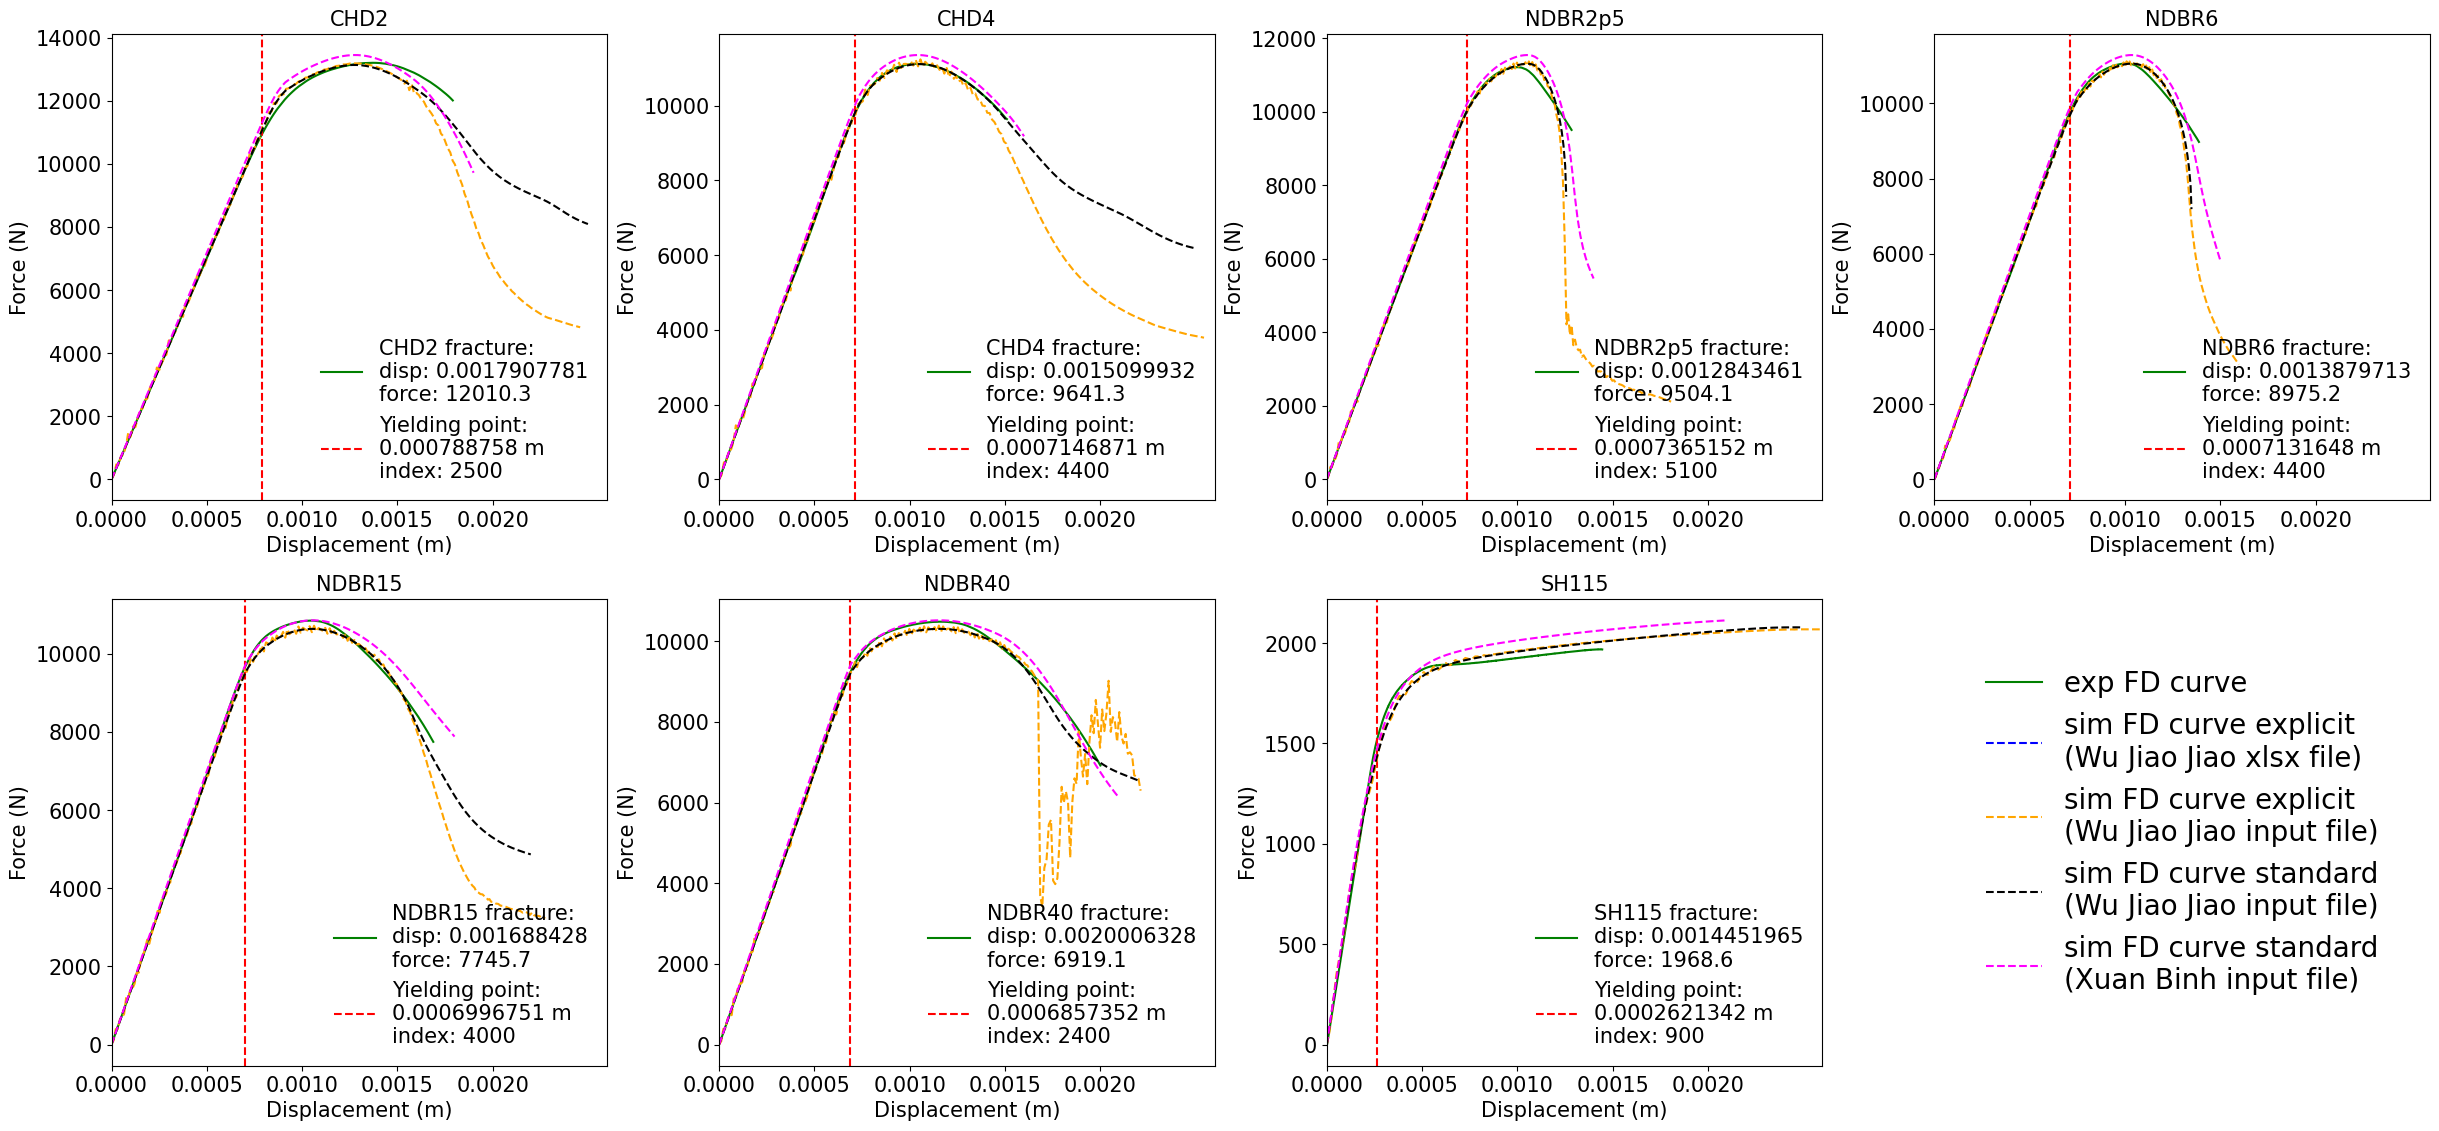

In [39]:
from utils.calculation import find_exp_yielding_index
from utils.IO import read_FD_curve
from utils.calculation import interpolating_force
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.tight_layout(pad=5.0)
ax = ax.ravel()

manual_yielding_index = {
    "CHD2": 2500, 
    "CHD4": 4400,
    "NDBR2p5": 5100,
    "NDBR6": 4400,
    "NDBR15": 4000,
    "NDBR40": 2400,
    "SH115": 900
}

total_satisfied_points = 0

for i, objective in enumerate(objectives):
    # Plotting the mean experimental FD curve
    FD_curve_final = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", engine='openpyxl')
    exp_displacement = FD_curve_final['displacement/m']
    exp_force = FD_curve_final['force/N']
    fracture_disp = FD_curve_final['displacement/m'].iloc[-1]
    fracture_force = FD_curve_final['force/N'].iloc[-1]
    fracture_disp = round(fracture_disp, 10)
    fracture_force = round(fracture_force, 1)
    ax[i].plot(exp_displacement, exp_force, label=f"{objective} fracture:\ndisp: {fracture_disp}\nforce: {fracture_force}",
               color='green')
    
    # Plotting the yielding point
    # Find automatic
    # yielding_index = find_exp_yielding_index(displacement, force, R_squared_threshold = 0.9999)
    
    # Manual
    yielding_index = manual_yielding_index[objective]
    
    ax[i].axvline(x = exp_displacement[yielding_index], color='r', linestyle='--', 
                  label=f"Yielding point:\n{round(exp_displacement[yielding_index], 10)} m\nindex: {yielding_index}")

    # Plotting the explicit simulation FD curve from Wu Jiao Jiao xlsx file 
    # if os.path.exists(f"{targets_path}/{objective}/FD_curve_sim_explicit_excel.xlsx"):
    #     sim_explicit_df = pd.read_excel(f"{targets_path}/{objective}/FD_curve_sim_explicit_excel.xlsx", engine='openpyxl')
    #     displacement_ref = sim_explicit_df['displacement/m'].to_numpy()
    #     force_ref = sim_explicit_df['force/N'].to_numpy()
    #     ax[i].plot(displacement_ref, force_ref, linestyle='--', color='blue')

    # Plotting the explicit simulation FD curve from Wu Jiao Jiao Abaqus input file
    if os.path.exists(f"{targets_path}/{objective}/FD_curve_sim_explicit_inp.txt"):
        displacement_ref, force_ref = read_FD_curve(f"{targets_path}/{objective}/FD_curve_sim_explicit_inp.txt")
        displacement_ref = displacement_ref/1000
        ax[i].plot(displacement_ref, force_ref, linestyle='--', color='orange')
    
    # Plotting the standard simulation FD curve from Wu Jiao Jiao Abaqus input file
    if os.path.exists(f"{targets_path}/{objective}/FD_curve_sim_standard_inp.txt"):
        displacement_ref, force_ref = read_FD_curve(f"{targets_path}/{objective}/FD_curve_sim_standard_inp.txt")
        displacement_ref = displacement_ref/1000
        ax[i].plot(displacement_ref, force_ref, linestyle='--', color='black')

    
    # Plotting the standard simulation FD curve from Xuan Binh Abaqus input file
    if os.path.exists(f"{targets_path}/{objective}/FD_curve_sim_standard.txt"):
        displacement_ref, force_ref = read_FD_curve(f"{targets_path}/{objective}/FD_curve_sim_standard.txt")
        interpolated_target_force = interpolating_force(exp_displacement, exp_force, displacement_ref)
        
        max_target_force = max(interpolated_target_force)
        deviation_force = max_target_force * 0.015
        target_force_upper = interpolated_target_force + deviation_force
        target_force_lower = interpolated_target_force - deviation_force
        
        num_satisfied_points = 0
        for index in range(len(interpolated_target_force)):
            if force_ref[index] >= target_force_lower[index] and force_ref[index] <= target_force_upper[index]:
                num_satisfied_points += 1
        print(f"Number of satisfied points for {objective} is {num_satisfied_points} out of {len(interpolated_target_force)}")
        total_satisfied_points += num_satisfied_points

        ax[i].plot(displacement_ref, force_ref, linestyle='--', color='magenta')

    ax[i].set_title(f"{objective}", fontsize=15)
    ax[i].set_xlabel("Displacement (m)", fontsize=15)
    ax[i].set_ylabel("Force (N)", fontsize=15)
    ax[i].set_xlim(0.0001, 0.0026)
    
    ax[i].xaxis.set_tick_params(labelsize=15)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].set_xticks([0.0, 0.0005, 0.001, 0.0015, 0.002])
    ax[i].legend(frameon=False, fontsize=15, loc=4)

print(f"Total number of satisfied points are {total_satisfied_points}")

ax[7].plot([],[],color="green", label="exp FD curve")
ax[7].plot([],[],color="blue", label="sim FD curve explicit\n(Wu Jiao Jiao xlsx file)", linestyle='--')
ax[7].plot([],[],color="orange", label="sim FD curve explicit\n(Wu Jiao Jiao input file)", linestyle='--')
ax[7].plot([],[],color="black", label="sim FD curve standard\n(Wu Jiao Jiao input file)", linestyle='--')
ax[7].plot([],[],color="magenta", label="sim FD curve standard\n(Xuan Binh input file)", linestyle='--')
ax[7].legend(loc="center", frameon=False, fontsize=20)
ax[7].axis('off')

plt.show()

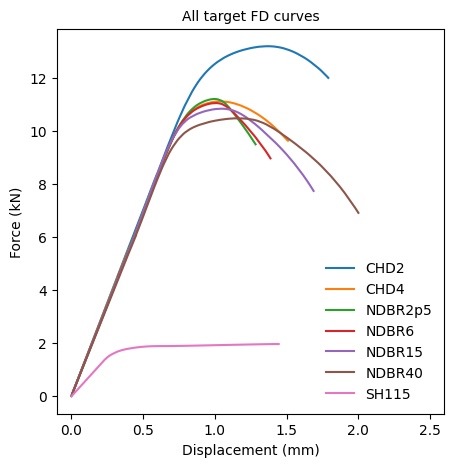

In [40]:
### Now we plot all target curves in one figure

plt.figure(figsize=(5, 5))
for objective in objectives:
    FD_curve_final = pd.read_excel(f"{targets_path}/{objective}/FD_curve_final.xlsx", engine='openpyxl')
    exp_displacement = FD_curve_final['displacement/mm']
    exp_force = FD_curve_final['force/kN']
    plt.plot(exp_displacement, exp_force, label=f"{objective}")

plt.xlim(-0.1, 2.6)
plt.xlabel("Displacement (mm)", fontsize=10)
plt.ylabel("Force (kN)", fontsize=10)
plt.title("All target FD curves", fontsize=10)
plt.legend(fontsize=10, frameon=False, loc=4)